In [141]:
%%capture
!pip install yellowbrick  
!pip install plotly


In [1]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import InterclusterDistance
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px



import pandas as pd
import numpy as np

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

In [3]:
# read data 
X_train = pd.read_csv('https://raw.githubusercontent.com/lunapapa-finland/EDISS-ML-Clustering/main/data/human%2Bactivity%2Brecognition%2Busing%2Bsmartphones/UCI%20HAR%20Dataset/train/X_train.txt', sep='\s+', header=None)
y_train = pd.read_csv('https://raw.githubusercontent.com/lunapapa-finland/EDISS-ML-Clustering/main/data/human%2Bactivity%2Brecognition%2Busing%2Bsmartphones/UCI%20HAR%20Dataset/train/y_train.txt', sep='\s+', header=None)
X_test = pd.read_csv('https://raw.githubusercontent.com/lunapapa-finland/EDISS-ML-Clustering/main/data/human%2Bactivity%2Brecognition%2Busing%2Bsmartphones/UCI%20HAR%20Dataset/test/X_test.txt', sep='\s+', header=None)
y_test = pd.read_csv('https://raw.githubusercontent.com/lunapapa-finland/EDISS-ML-Clustering/main/data/human%2Bactivity%2Brecognition%2Busing%2Bsmartphones/UCI%20HAR%20Dataset/test/y_test.txt', sep='\s+', header=None)


In [4]:
# add subject features and rename column name using features.txt 
def processing_df(df_X, df_y, type):
    # Read new column name from a text file
    feature_names = pd.read_csv('https://raw.githubusercontent.com/lunapapa-finland/EDISS-ML-Clustering/main/data/human%2Bactivity%2Brecognition%2Busing%2Bsmartphones/UCI%20HAR%20Dataset/features.txt', sep='\s+', header=None)
    df_X.columns = feature_names[1].tolist()
    df_y.columns = ['activity']
    
    if type == 'train':
        subject_data = pd.read_csv('https://raw.githubusercontent.com/lunapapa-finland/EDISS-ML-Clustering/main/data/human%2Bactivity%2Brecognition%2Busing%2Bsmartphones/UCI%20HAR%20Dataset/train/subject_train.txt', sep='\s+', header=None)
        df_y['subject'] = subject_data[0]

        
    elif type == 'test':
        subject_data = pd.read_csv('https://raw.githubusercontent.com/lunapapa-finland/EDISS-ML-Clustering/main/data/human%2Bactivity%2Brecognition%2Busing%2Bsmartphones/UCI%20HAR%20Dataset/test/subject_test.txt', sep='\s+', header=None)
        df_y['subject'] = subject_data[0]
 
    else: 
        raise ValueError('Invalid type. Must be "train" or "test".')
    
    df_y['subject_activity'] = df_y['subject'].astype(str) + '_' + df_y['activity'].astype(str)
    
    return df_X, df_y

# add subject features and rename column name using features.txt 
X_train, y_train = processing_df(X_train, y_train, 'train')
X_test, y_test = processing_df(X_test, y_test,'test')
X = pd.concat([X_train, X_test], axis=0)
y= pd.concat([y_train, y_test], axis=0)    

In [5]:
df = pd.concat([X, y], axis=1)
df_subject_activity = df.drop(['subject', 'activity'], axis = 1).groupby('subject_activity').mean()
df_subject = df.drop(['subject_activity', 'activity'], axis = 1).groupby('subject').mean()
df_activity = df.drop(['subject', 'subject_activity'], axis = 1).groupby('activity').mean()
df.drop(['subject','activity','subject_activity'], axis = 1, inplace = True)
print(df.shape)
print(df_subject_activity.shape)
print(df_subject.shape)
print(df_activity.shape)

(10299, 561)
(180, 561)
(30, 561)
(6, 561)


## Cluster Using K Means: Function Definition

In [146]:
def KMeans_elbow(df):
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
    
    # Then continue with your code
    km = KMeans(random_state=42, n_init='auto')
    visualizer = KElbowVisualizer(km, k=(2,20))
    visualizer.fit(df)
    visualizer.show()

#### For a particular K, all the clusters should have a Silhouette score greater than the average score of the data set represented by the red-dotted line. The x-axis represents the Silhouette score. The clusters with K=3 get eliminated because it doesn’t follow this condition.
#### There shouldn’t be wide fluctuations in the size of the clusters. The width of the clusters represents the number of data points. For K=3 to 9, the data points distribution are not even enough.

In [147]:
def KMeans_silhouette(df):
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
    
        for i in [2, 3, 4, 5, 6, 7, 8]:
            km = KMeans(n_clusters=i, init='k-means++', n_init='auto', max_iter=100, random_state=42)
            km.fit(df)
            cluster_labels = km.predict(df)
            silhouette_avg = silhouette_score(df, cluster_labels)
            print(f'Average Silhouette score for {i} clusters: {silhouette_avg}')
        
            # Plot Silhouette visualization
            fig, ax = plt.subplots(1, 2, figsize=(10, 4))
            q, mod = divmod(i, 2)
            visualizer_silhouette = SilhouetteVisualizer(KMeans(n_clusters=i, init='k-means++', n_init='auto', max_iter=100, random_state=42), colors='yellowbrick', ax=ax[0])
            visualizer_silhouette.fit(df)
        
            # Plot InterclusterDistance visualization
            visualizer_intercluster = InterclusterDistance(KMeans(n_clusters=i, init='k-means++', n_init='auto', max_iter=100, random_state=42), ax=ax[1])
            visualizer_intercluster.fit(df)
            visualizer_intercluster.poof()
        
            plt.show()


## Clustering using DBSCAN: Function Definition

In [148]:
# Define a function to perform grid search for DBSCAN
def dbscan_grid_search(X, eps_values, min_samples_values, type):
    best_score = -1
    best_eps = None
    best_min_samples = None
    best_cluster_labels = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(X)
            
            # Check if DBSCAN creates multiple clusters
            if len(np.unique(cluster_labels)) > 1:
                silhouette_avg = silhouette_score(X, cluster_labels)
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_eps = eps
                    best_min_samples = min_samples
                    best_cluster_labels = cluster_labels
    print(f'Best parameters for {type}: EPS: {best_eps}, Min Samples: {best_min_samples}')
    return best_eps, best_min_samples, best_cluster_labels

In [149]:
def cluster_analysis(X, eps, min_samples, type):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    DBSCAN_dataset = X.copy()
    DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 
    print(f'Cluseters for {type} using best EPS: {eps}, best Min Samples: {min_samples}')
    print(DBSCAN_dataset.Cluster.value_counts().to_frame())

In [150]:
def visualize_dbscan(df):

    PC1 = df['PC1']
    PC2 = df['PC2']
    PC3 = df['PC3']
    Cluster = df['Cluster']

    unique_labels = Cluster.unique()

    # Create a figure to hold the 3D scatter plot
    fig = go.Figure()

    # Iterate over unique cluster labels and create traces for each
    for cluster_label in unique_labels:
        cluster_indices = Cluster[Cluster == cluster_label].index
        scatter_trace = go.Scatter3d(
            x=PC1.loc[cluster_indices],
            y=PC2.loc[cluster_indices],
            z=PC3.loc[cluster_indices],
            mode='markers',
            marker=dict(
                size=5,
                color=cluster_label,  # Each cluster gets a different color
                opacity=0.8,
                line=dict(color='rgb(0,0,0)', width=0.5)
            ),
            name=f'Cluster {cluster_label}'
        )
        fig.add_trace(scatter_trace)

    # Update layout with axis labels
    fig.update_layout(scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ))

    # Show the figure
    fig.show()
    

## PCA Function Definition

In [151]:
def apply_pca(df, n_components=2):
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(df)
    
    # Create a DataFrame with the transformed features
    pca_columns = [f'PC{i}' for i in range(1, n_components + 1)]
    pca_df = pd.DataFrame(data=pca_features, columns=pca_columns, index=df.index)
    
    return pca_df

In [152]:
def find_best_PCA(df):
    pca = PCA()
    pca.fit(df)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components')
    plt.show()

## Clustering without PCA

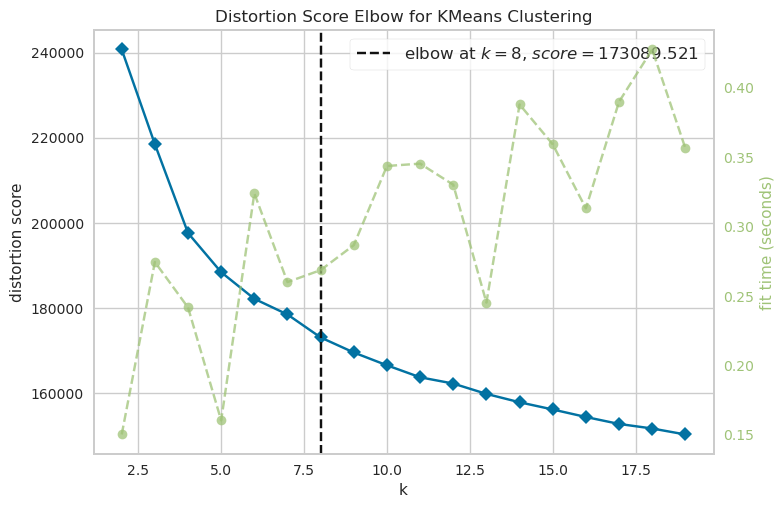

Average Silhouette score for 2 clusters: 0.48107627299425504


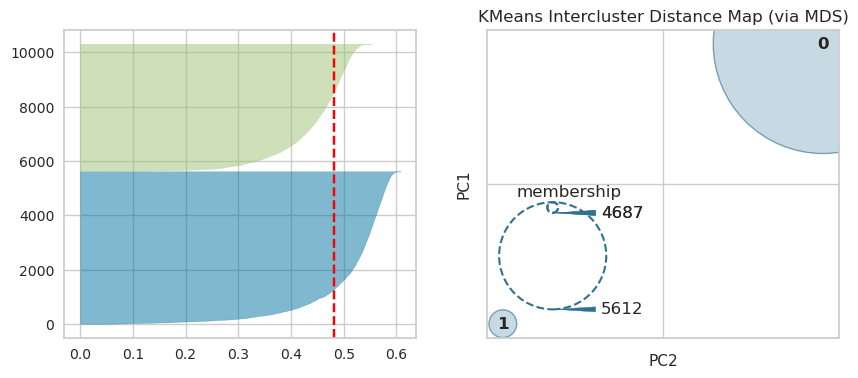

Average Silhouette score for 3 clusters: 0.32422933603895726


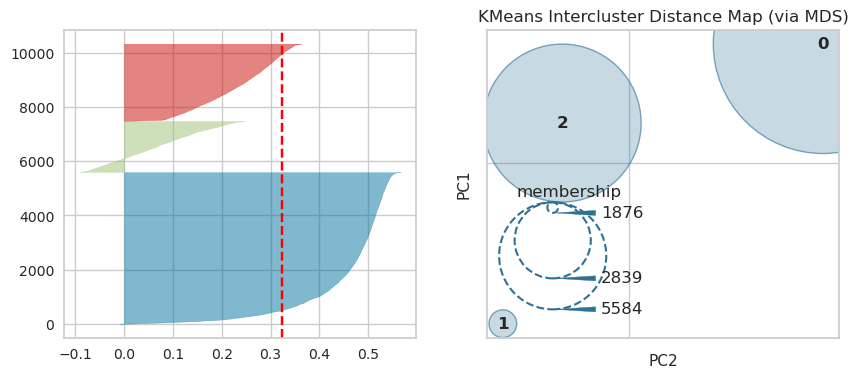

Average Silhouette score for 4 clusters: 0.18655778302064754


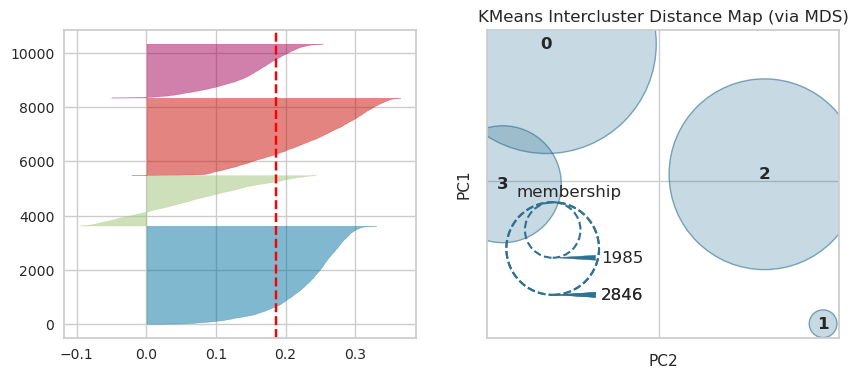

Average Silhouette score for 5 clusters: 0.16434192266069156


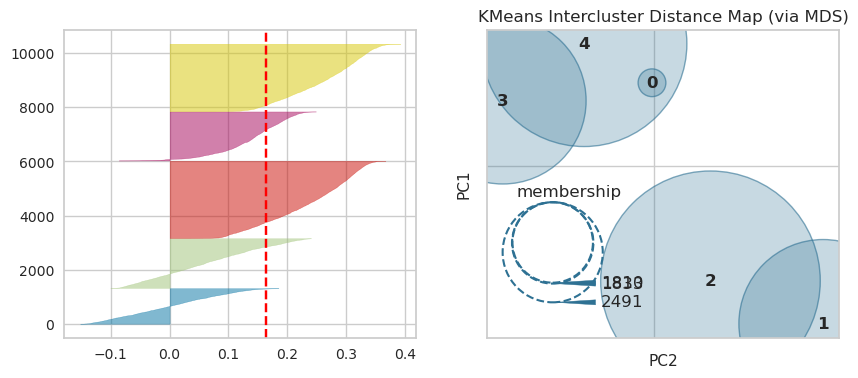

Average Silhouette score for 6 clusters: 0.13238734952958364


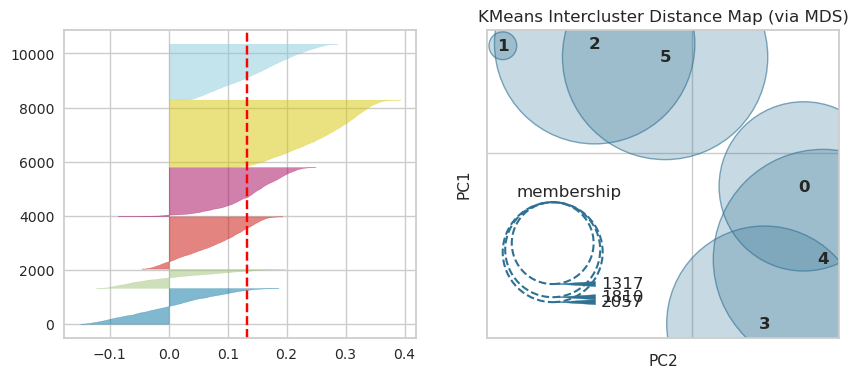

Average Silhouette score for 7 clusters: 0.12983993547723158


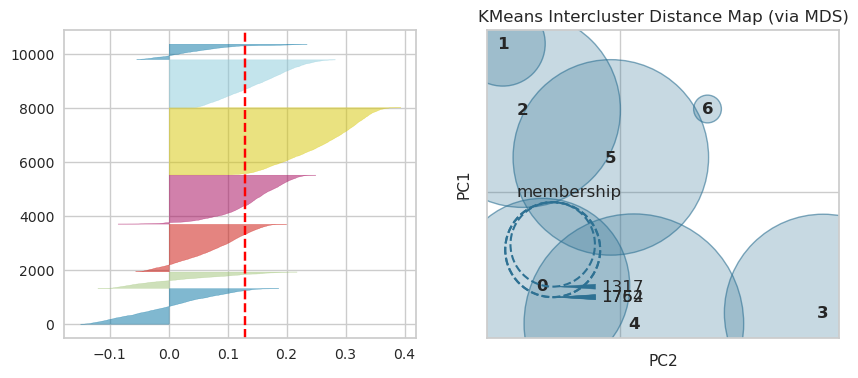

Average Silhouette score for 8 clusters: 0.10807833328822623


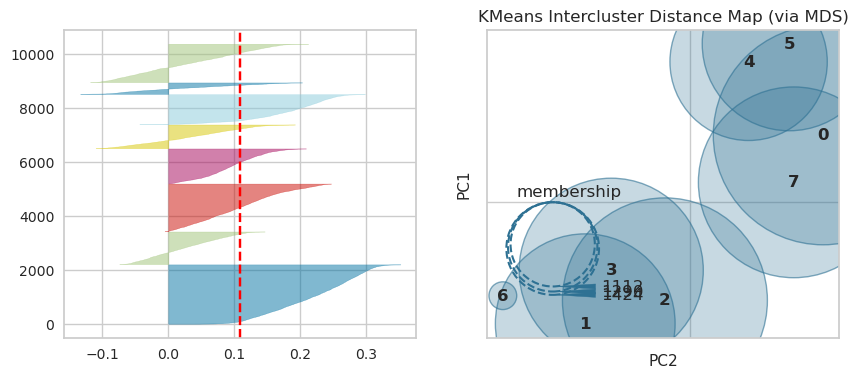

In [153]:
# Elbow to find Best K in K means
KMeans_elbow(df)
# Silhouette to find Best K in K means
KMeans_silhouette(df)

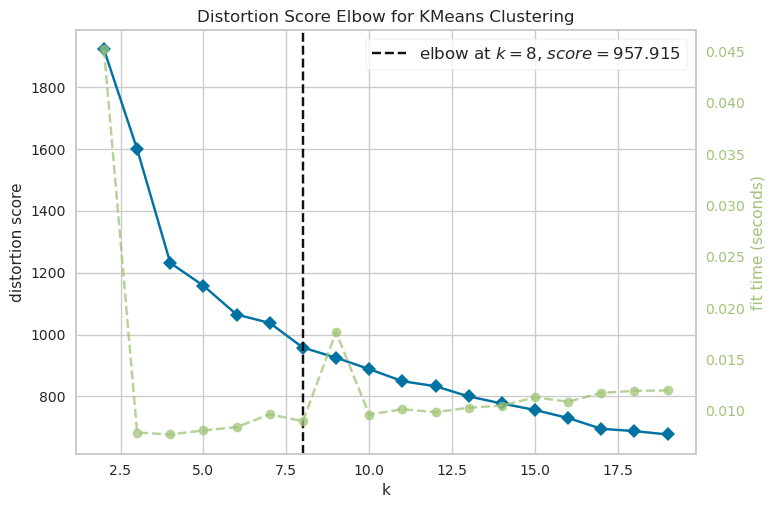

Average Silhouette score for 2 clusters: 0.6390153960135811


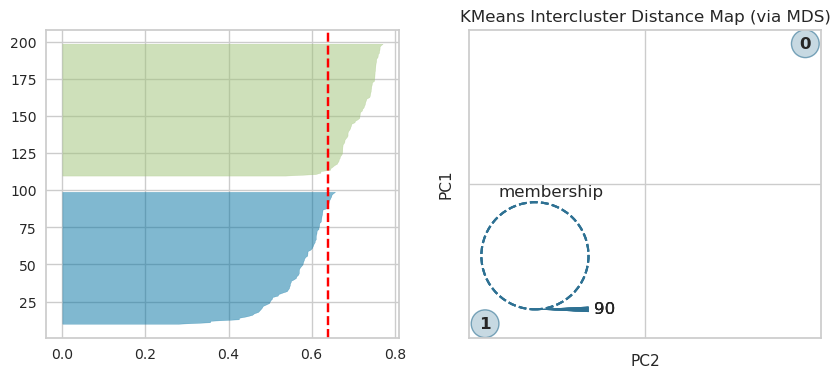

Average Silhouette score for 3 clusters: 0.5194052836568013


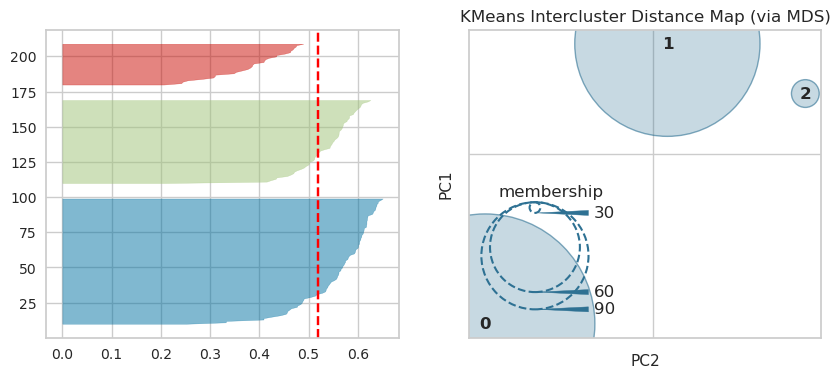

Average Silhouette score for 4 clusters: 0.35966231619777017


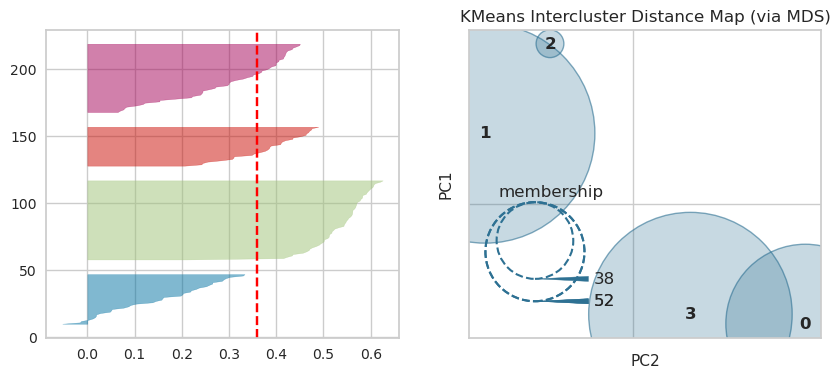

Average Silhouette score for 5 clusters: 0.3440382444669773


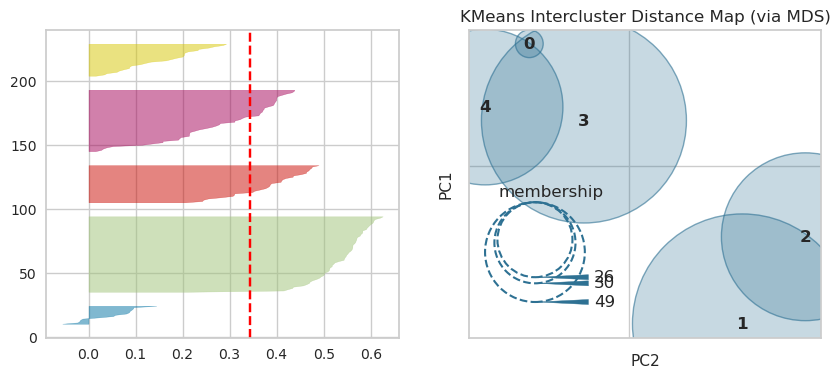

Average Silhouette score for 6 clusters: 0.3078165150528575


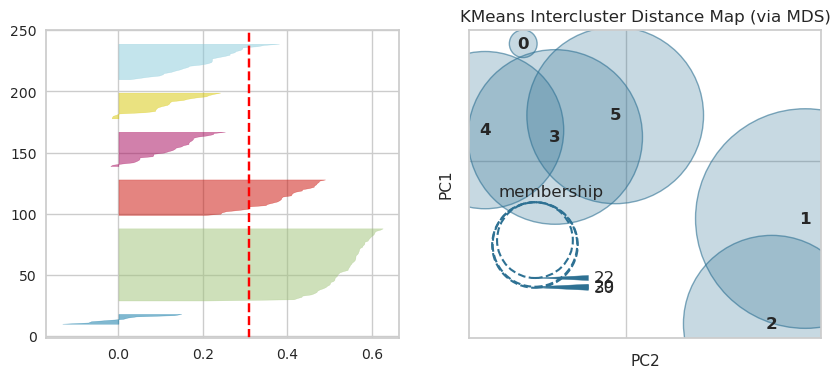

Average Silhouette score for 7 clusters: 0.29357566369260296


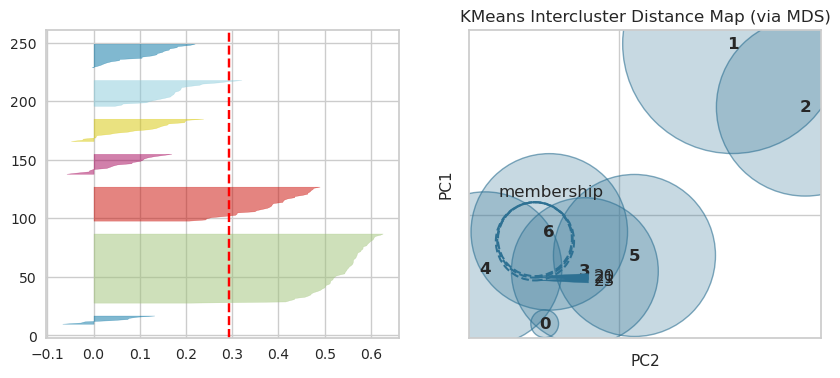

Average Silhouette score for 8 clusters: 0.3131079329441642


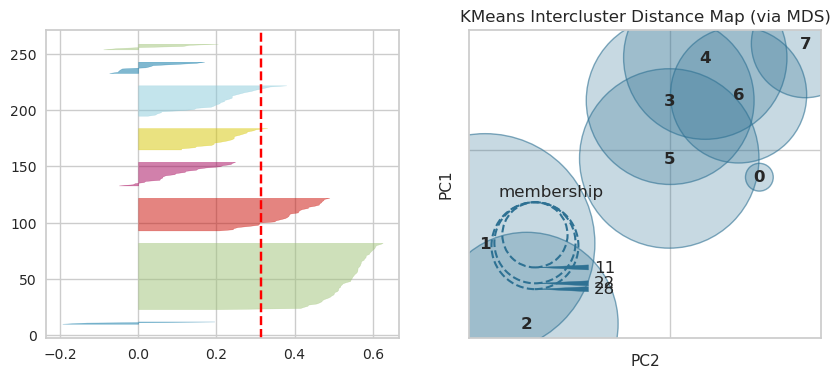

In [154]:
KMeans_elbow(df_subject_activity)
KMeans_silhouette(df_subject_activity)

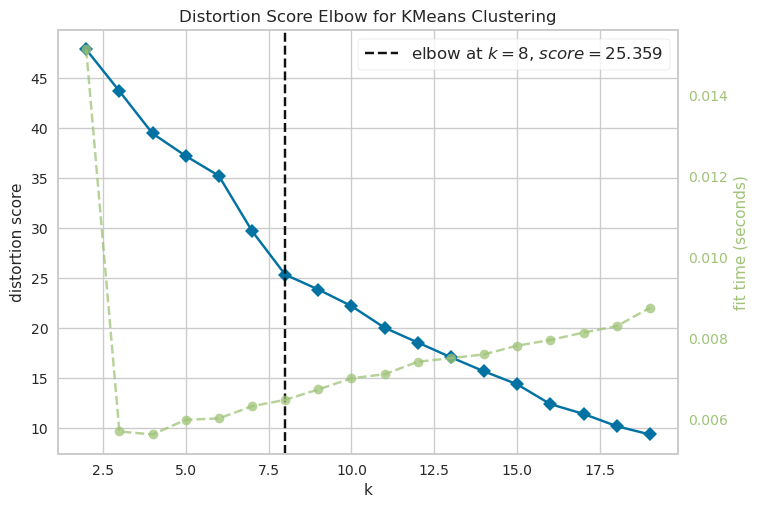

Average Silhouette score for 2 clusters: 0.22467114768548097


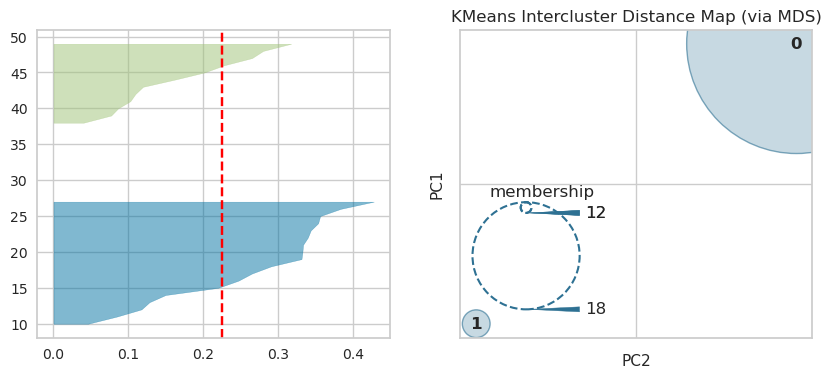

Average Silhouette score for 3 clusters: 0.16927627592213207


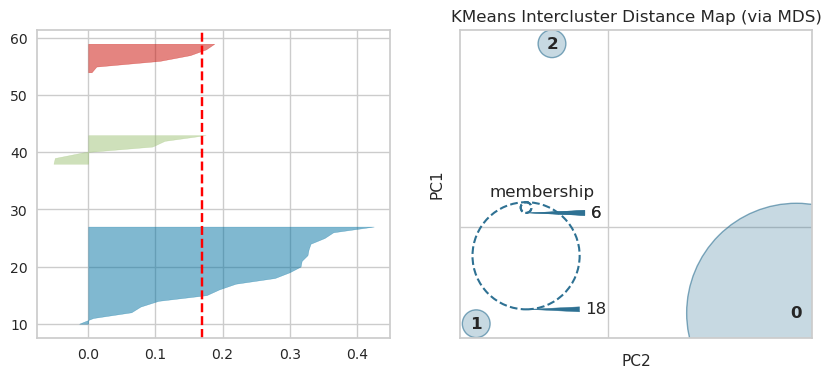

Average Silhouette score for 4 clusters: 0.11472480698478683


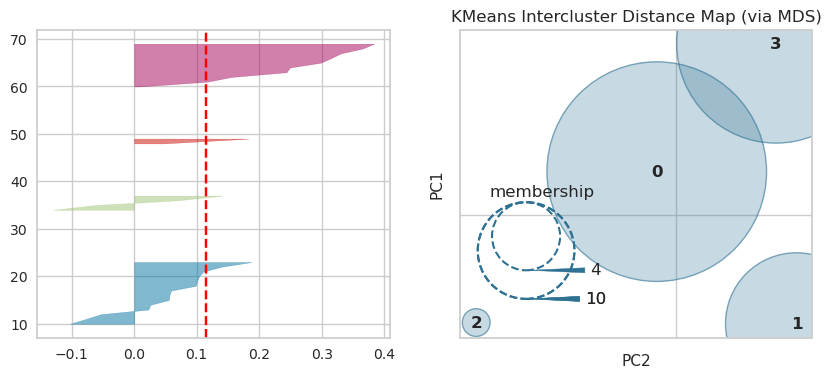

Average Silhouette score for 5 clusters: 0.09763749325423962


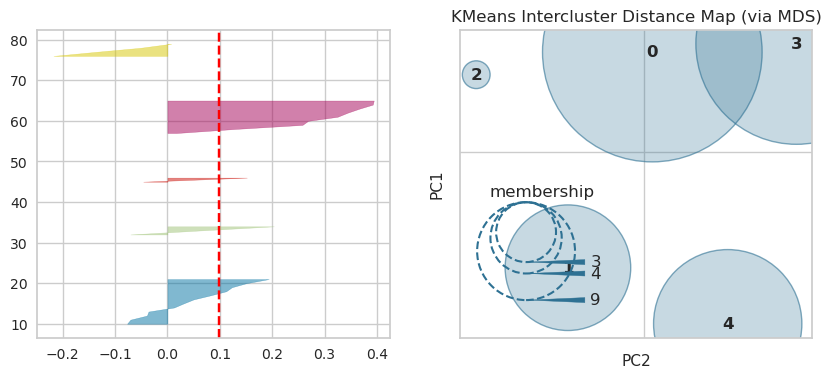

Average Silhouette score for 6 clusters: 0.08668267216918926


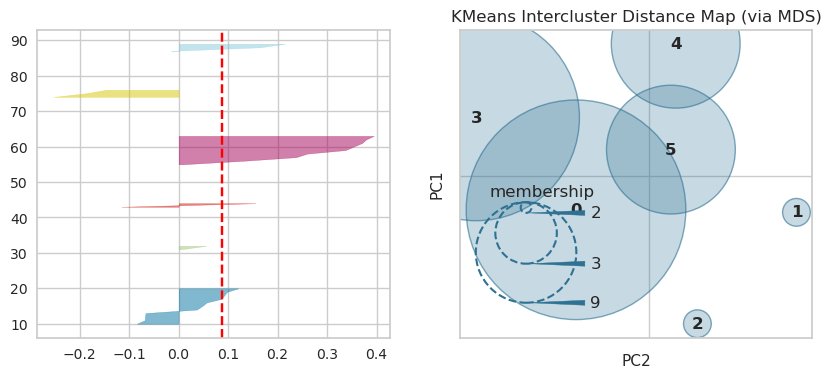

Average Silhouette score for 7 clusters: 0.1017443872321321


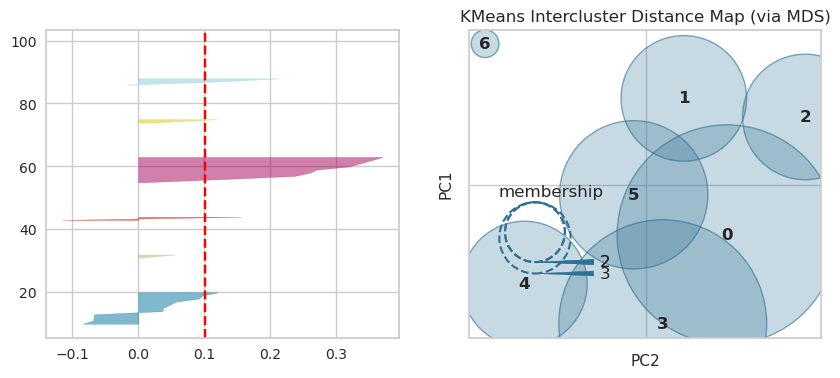

Average Silhouette score for 8 clusters: 0.10551664783798133


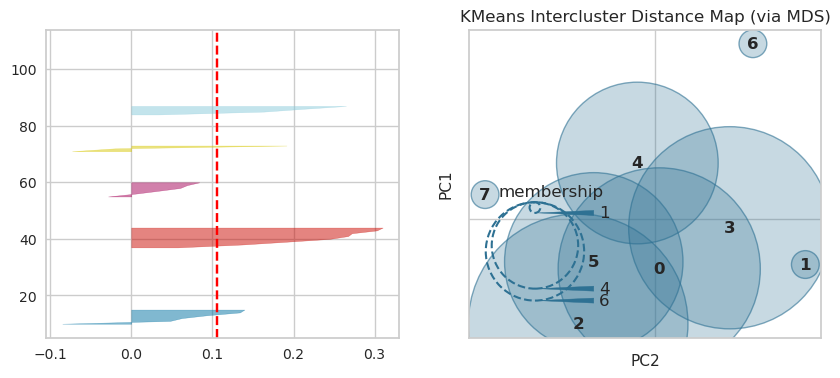

In [155]:
KMeans_elbow(df_subject)
KMeans_silhouette(df_subject)

In [156]:
# Perform grid search for DBSCAN
eps_values = [0.1, 0.5, 1.0, 1.5]
min_samples_values =  range(2,20)
best_eps, best_min_samples, best_cluster_labels = dbscan_grid_search(df, eps_values, min_samples_values, type = 'All Point')
# DBSCAN Cluster Analysis
cluster_analysis(df, best_eps, best_min_samples, type = 'All Point')

Best parameters for All Point: EPS: 1.5, Min Samples: 2
Cluseters for All Point using best EPS: 1.5, best Min Samples: 2
         count
Cluster       
-1       10287
 0           2
 1           2
 2           2
 3           2
 4           2
 5           2


In [157]:
best_eps_subject, best_min_samples_subject, best_cluster_labels_subject = dbscan_grid_search(df_subject, eps_values, min_samples_values, type = 'Subject Aggregation')
cluster_analysis(df_subject, best_eps_subject, best_min_samples_subject, type = 'Subject Aggregation')

Best parameters for Subject Aggregation: EPS: 1.5, Min Samples: 9
Cluseters for Subject Aggregation using best EPS: 1.5, best Min Samples: 9
         count
Cluster       
 0          19
-1          11


In [158]:
best_eps_subject_activity, best_min_samples_subject_activity, best_cluster_labels_subject_activity = dbscan_grid_search(df_subject_activity, eps_values, min_samples_values, type = 'Subject_activity Aggregation')
cluster_analysis(df_subject_activity, best_eps_subject_activity, best_min_samples_subject_activity, type = 'Subject_activity Aggregation')

Best parameters for Subject_activity Aggregation: EPS: 1.5, Min Samples: 5
Cluseters for Subject_activity Aggregation using best EPS: 1.5, best Min Samples: 5
         count
Cluster       
-1         126
 0          54


## Clustering with PCA

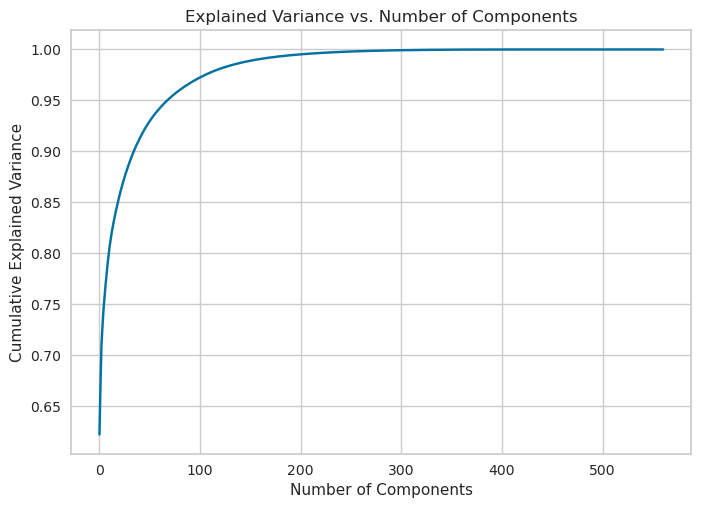

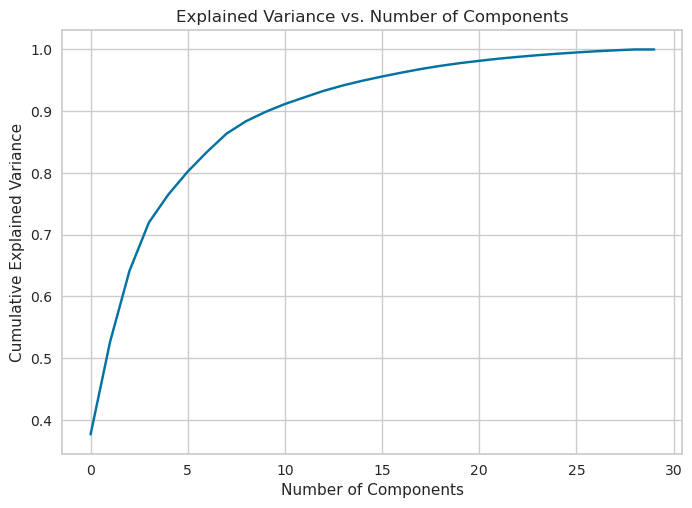

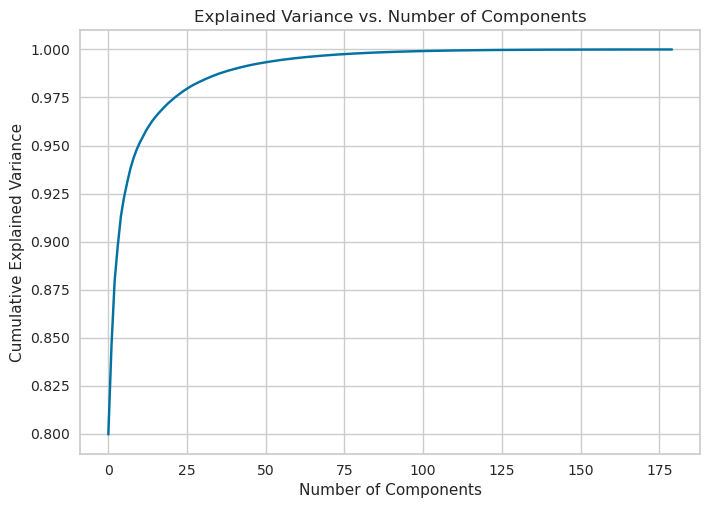

In [159]:
# draw PCA to explain variance ratio
find_best_PCA(df)
find_best_PCA(df_subject)
find_best_PCA(df_subject_activity)

In [160]:
## Choose PCA component = 3 for visulization purpose and do clustering
pca_df = apply_pca(df, n_components=3)
pca_df_subject = apply_pca(df_subject, n_components=3)
pca_df_subject_activity = apply_pca(df_subject_activity, n_components=3)


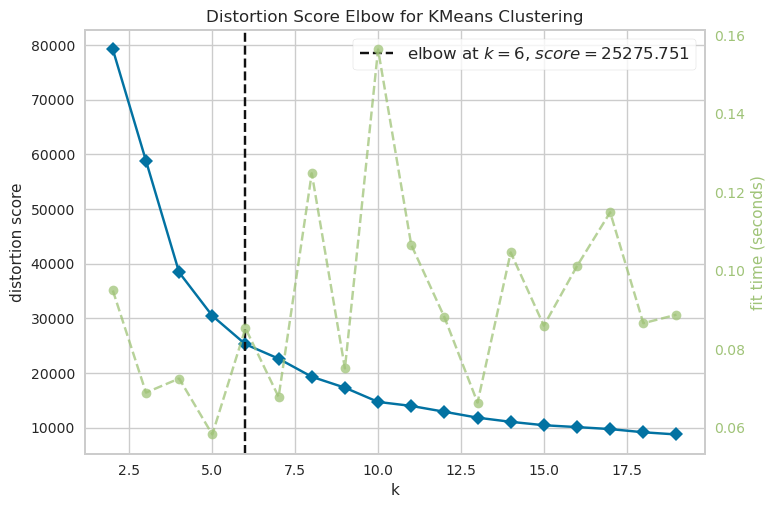

Average Silhouette score for 2 clusters: 0.701291316897987


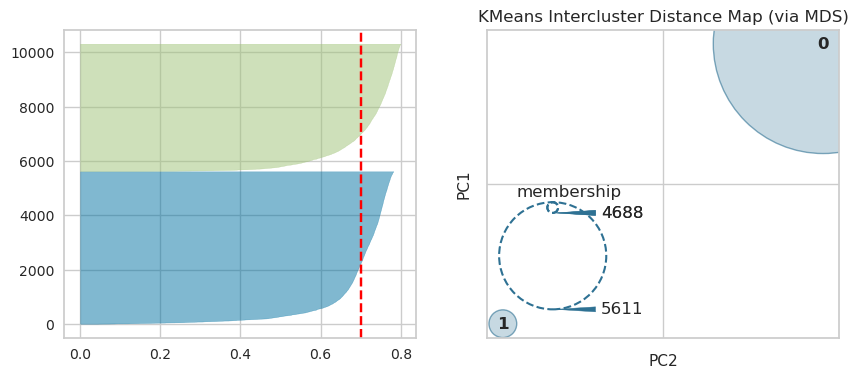

Average Silhouette score for 3 clusters: 0.5695574542642449


/ediss_data/ediss6/euli/miniconda3/envs/NLP/lib/python3.8/site-packages/sklearn/manifold/_mds.py:601: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



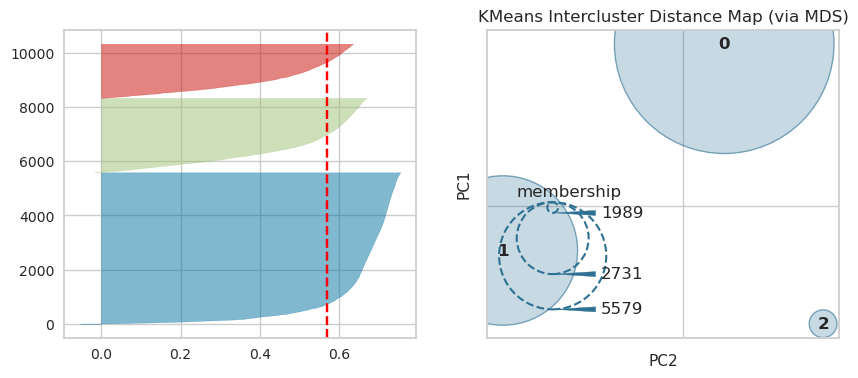

Average Silhouette score for 4 clusters: 0.48623757468049456


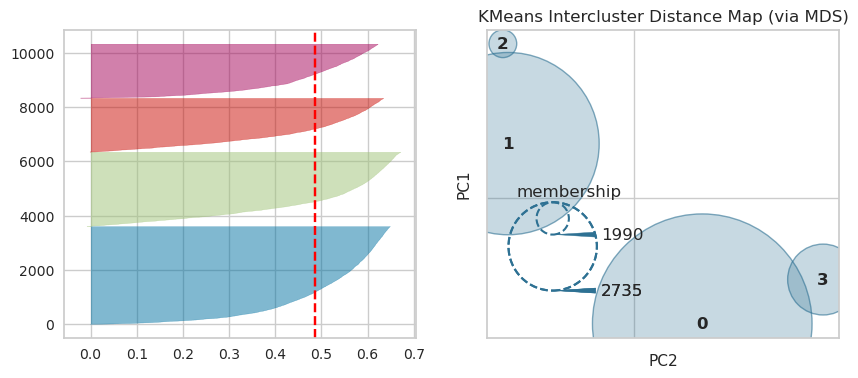

Average Silhouette score for 5 clusters: 0.47427915424101014


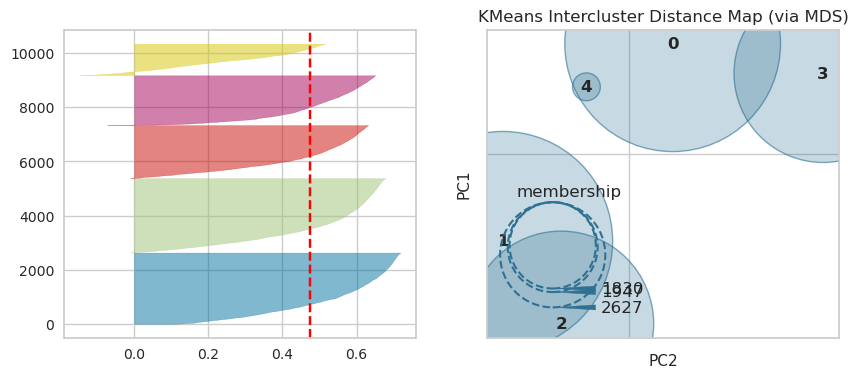

Average Silhouette score for 6 clusters: 0.43892945057997557


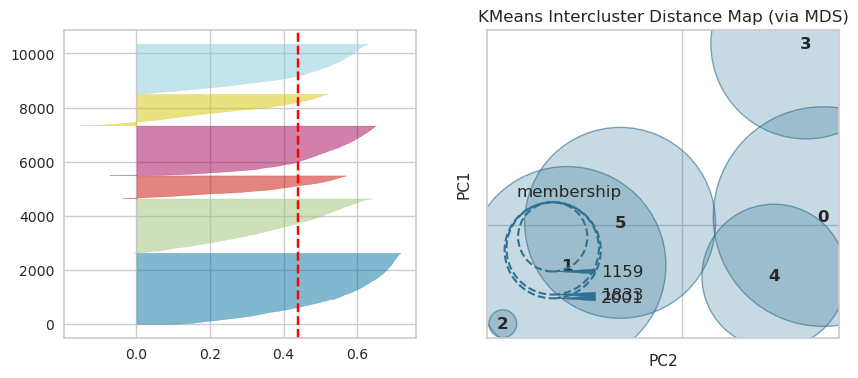

Average Silhouette score for 7 clusters: 0.42642457293858893


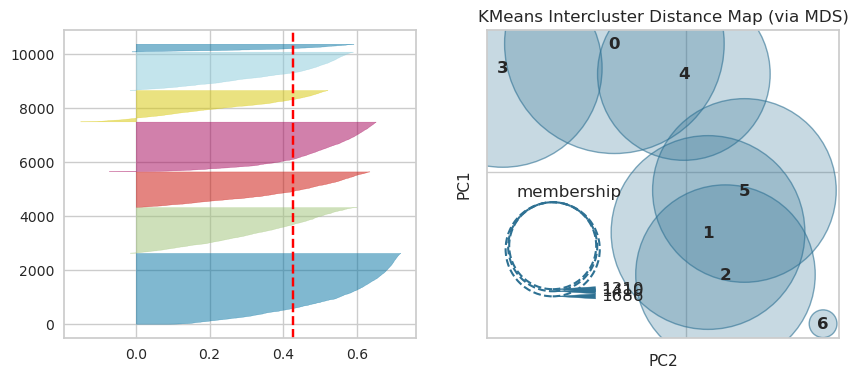

Average Silhouette score for 8 clusters: 0.41768640187827155


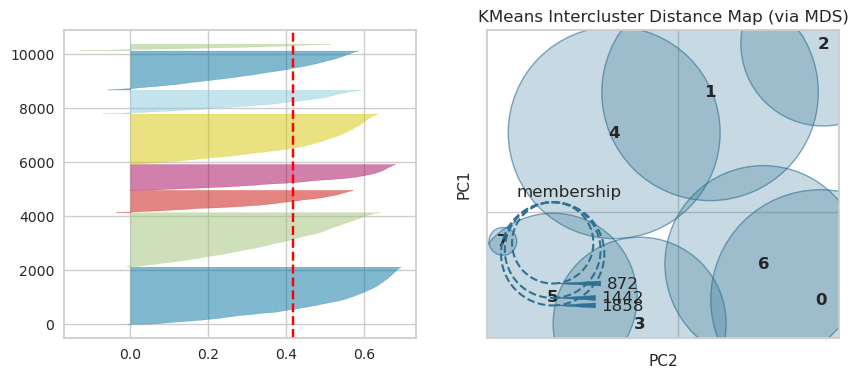

In [161]:
# Elbow to find Best K in K means
KMeans_elbow(pca_df)
# Silhouette to find Best K in K means
KMeans_silhouette(pca_df)

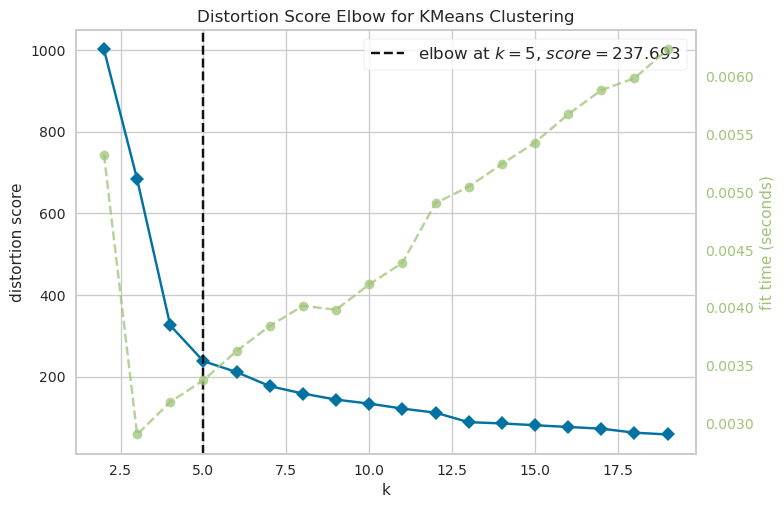

Average Silhouette score for 2 clusters: 0.7565795679003181


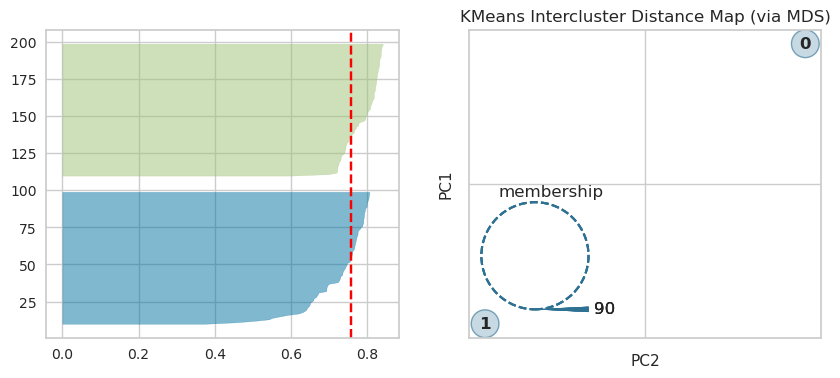

Average Silhouette score for 3 clusters: 0.7227283133646517


/ediss_data/ediss6/euli/miniconda3/envs/NLP/lib/python3.8/site-packages/sklearn/manifold/_mds.py:601: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



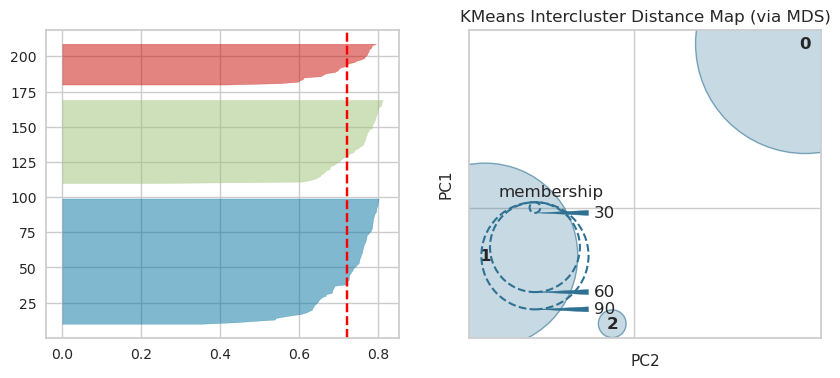

Average Silhouette score for 4 clusters: 0.6098617394682453


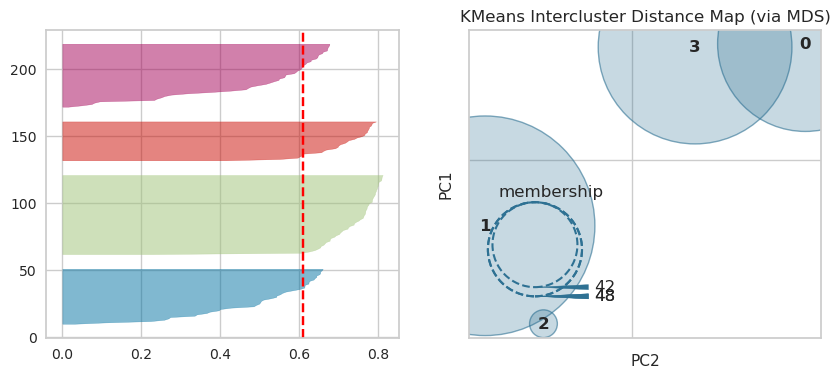

Average Silhouette score for 5 clusters: 0.5712717963169727


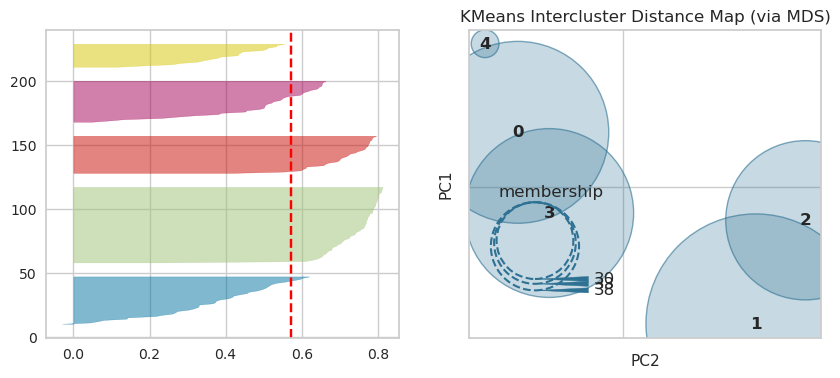

Average Silhouette score for 6 clusters: 0.5329297289649598


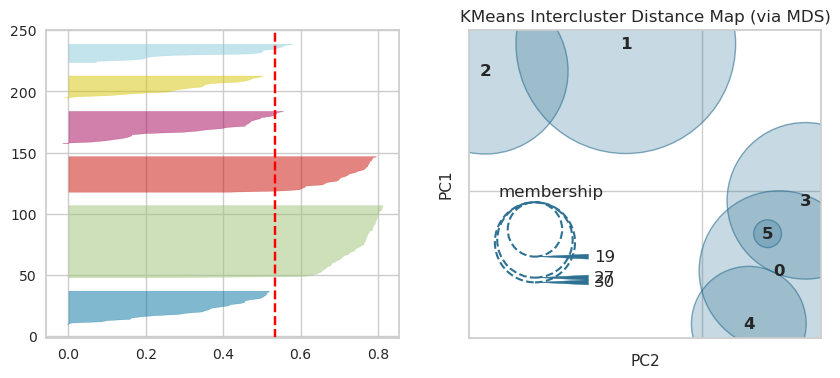

Average Silhouette score for 7 clusters: 0.5551250481932571


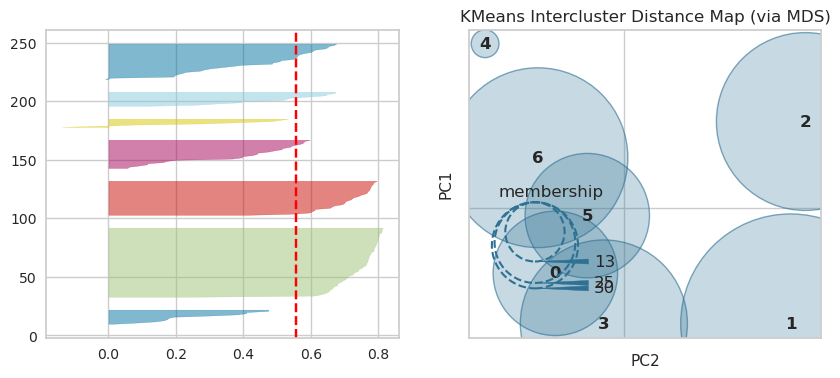

Average Silhouette score for 8 clusters: 0.5284760831231587


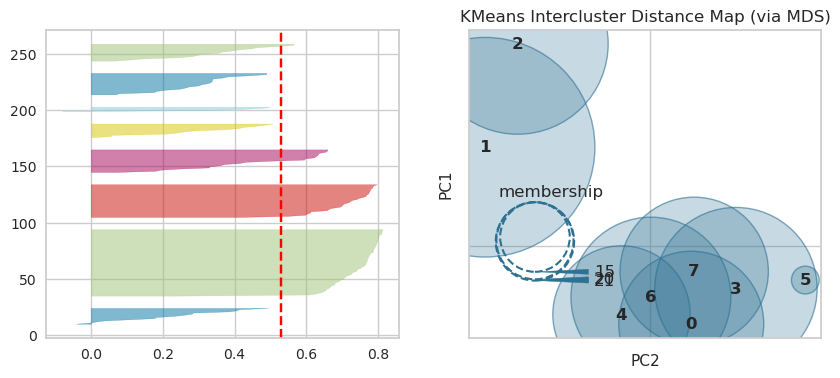

In [162]:
KMeans_elbow(pca_df_subject_activity)
KMeans_silhouette(pca_df_subject_activity)

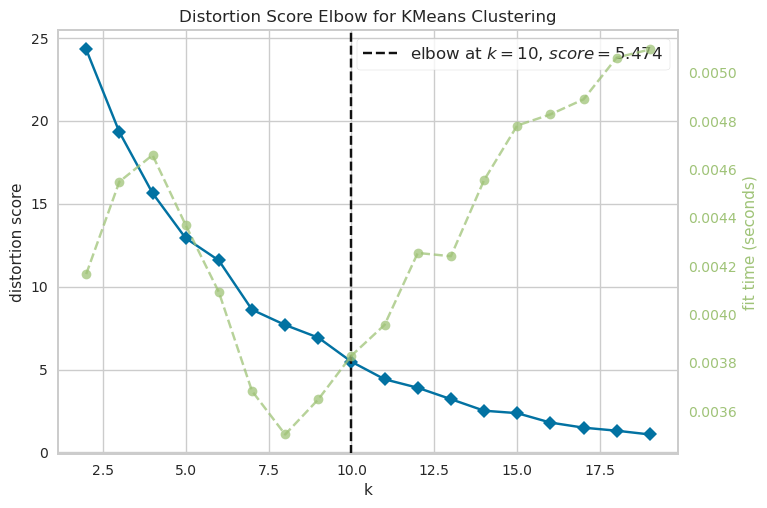

Average Silhouette score for 2 clusters: 0.34721338448321026


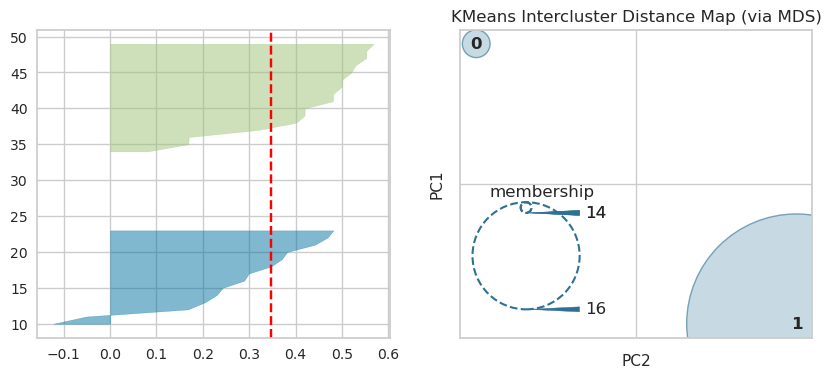

Average Silhouette score for 3 clusters: 0.2526536820574388


/ediss_data/ediss6/euli/miniconda3/envs/NLP/lib/python3.8/site-packages/sklearn/manifold/_mds.py:601: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



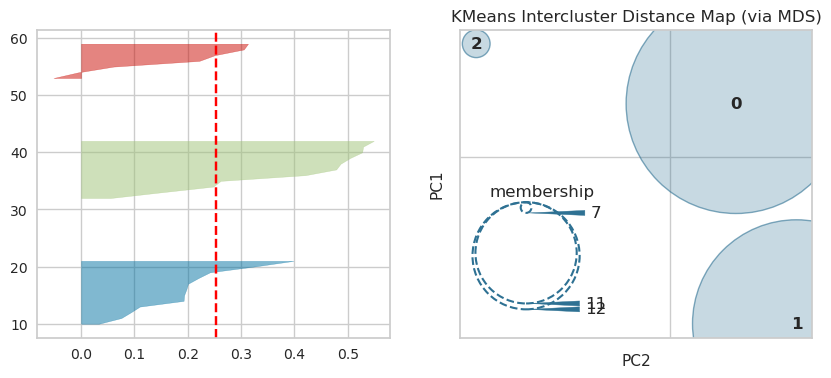

Average Silhouette score for 4 clusters: 0.25314320989379596


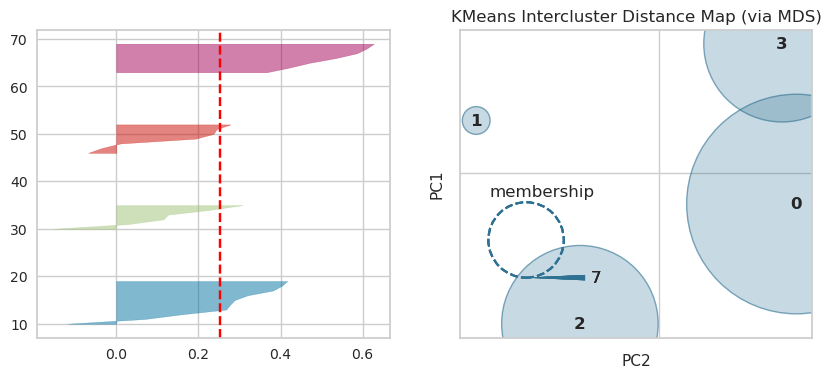

Average Silhouette score for 5 clusters: 0.21293650319890436


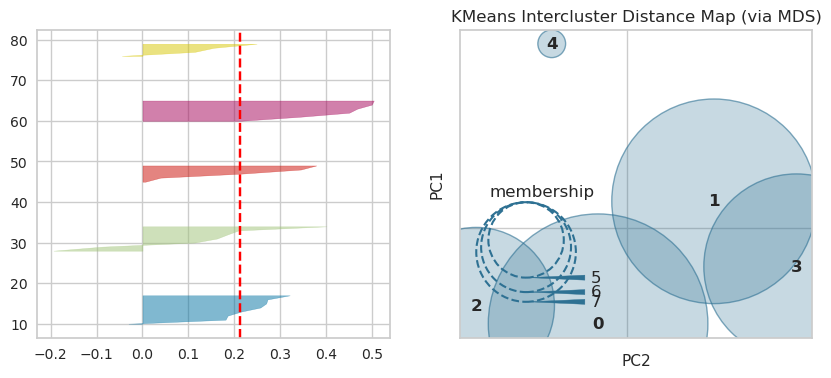

Average Silhouette score for 6 clusters: 0.21729411148892433


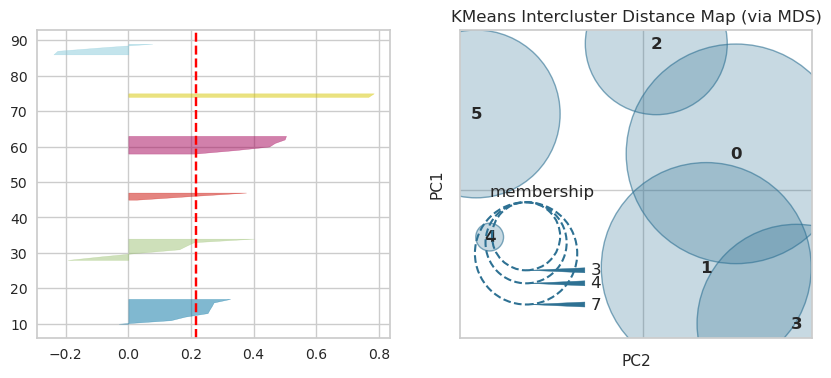

Average Silhouette score for 7 clusters: 0.22857459388584814


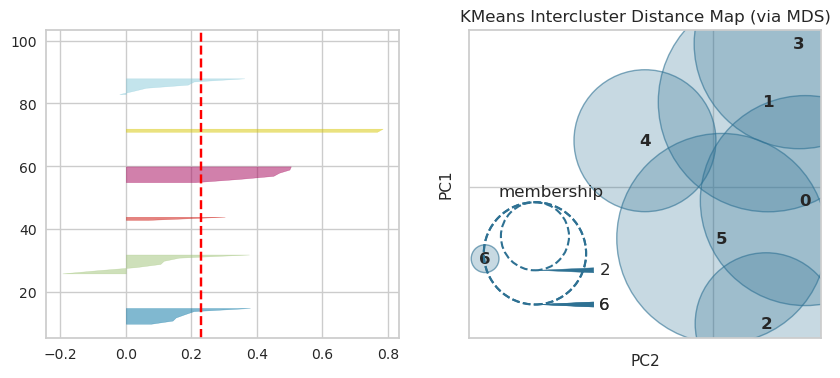

Average Silhouette score for 8 clusters: 0.2137413068722159


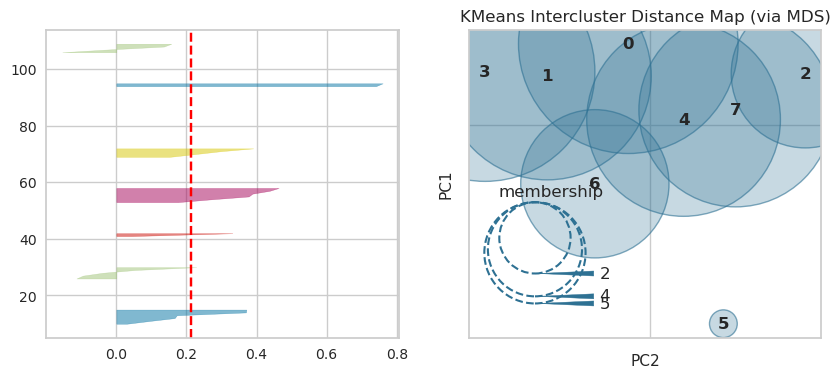

In [163]:
KMeans_elbow(pca_df_subject)
KMeans_silhouette(pca_df_subject)

In [164]:
# Perform grid search for DBSCAN
eps_values = [0.1, 0.5, 1.0, 1.5]
min_samples_values =  range(2,20)
pca_best_eps, pca_best_min_samples, pca_best_cluster_labels = dbscan_grid_search(pca_df, eps_values, min_samples_values, type = 'All Point')
# DBSCAN Cluster Analysis
cluster_analysis(pca_df, pca_best_eps, pca_best_min_samples, type = 'All Point')

Best parameters for All Point: EPS: 1.0, Min Samples: 14
Cluseters for All Point using best EPS: 1.0, best Min Samples: 14
         count
Cluster       
 0        5590
 1        4647
-1          62


In [165]:
pca_best_eps_subject, pca_best_min_samples_subject, pca_best_cluster_labels_subject = dbscan_grid_search(pca_df_subject, eps_values, min_samples_values, type = 'Subject Aggregation')
cluster_analysis(pca_df_subject, pca_best_eps_subject, pca_best_min_samples_subject, type = 'Subject Aggregation')

Best parameters for Subject Aggregation: EPS: 1.5, Min Samples: 2
Cluseters for Subject Aggregation using best EPS: 1.5, best Min Samples: 2
         count
Cluster       
 0          29
-1           1


In [166]:
pca_best_eps_subject_activity, pca_best_min_samples_subject_activity, pca_best_cluster_labels_subject_activity = dbscan_grid_search(pca_df_subject_activity, eps_values, min_samples_values, type = 'Subject_activity Aggregation')
cluster_analysis(pca_df_subject_activity, pca_best_eps_subject_activity, pca_best_min_samples_subject_activity, type = 'Subject_activity Aggregation')

Best parameters for Subject_activity Aggregation: EPS: 1.5, Min Samples: 2
Cluseters for Subject_activity Aggregation using best EPS: 1.5, best Min Samples: 2
         count
Cluster       
 0          88
 1          60
 2          29
-1           3


In [167]:
pca_df['Cluster'] = pca_best_cluster_labels
pca_df_subject['Cluster'] = pca_best_cluster_labels_subject
pca_df_subject_activity['Cluster'] = pca_best_cluster_labels_subject_activity
visualize_dbscan(pca_df)
visualize_dbscan(pca_df_subject)
visualize_dbscan(pca_df_subject_activity)

In [168]:
import plotly.graph_objects as go

df_analysis = pca_df_subject_activity.copy()  # Make a copy to avoid modifying the original DataFrame
df_analysis[['Subject', 'Activity']] = pca_df_subject_activity.index.str.split('_', expand=True).to_list()
df_analysis.reset_index(inplace=True)
df_analysis = df_analysis.sort_values(by='Cluster')

# Extracting data from the DataFrame
clusters = df_analysis['Cluster']
subjects = df_analysis['Subject']
activities = df_analysis['Activity']

# Define a color palette for each cluster
color_palette = {-1: 'red', 0: 'blue', 1: 'green', 2: 'orange'}

#Create a scatter plot
fig = go.Figure()

# Add scatter plot for each data point
for subject, activity, cluster in zip(subjects, activities, clusters):
    # Add each subject-activity pair as a scatter point with color based on cluster
    fig.add_trace(
        go.Scatter(
            x=[subject],
            y=[activity],
            mode='markers',
            marker=dict(color=color_palette[cluster]),
            showlegend=False
        )
    )

# Update layout
fig.update_layout(
    title='Subject-Activity Plot with Cluster Colors',
    xaxis=dict(title='Subject'),
    yaxis=dict(title='Activity'),
)

# Show the plot
fig.show()#
